In [1]:
from IPython.display import Image, display, Math, Latex, HTML, Javascript
from ipywidgets import widgets, interact, Layout, interactive 
import numpy as np
import math
import os
import matplotlib.pyplot as plt


In [2]:
#######################################
#        Functions                    #
#######################################

def D50(n, W, RhoP, Q, C, Stk50 = 0.23):
    """
    Returns the cut point diameter D50
    
    Parameters
    ----------
    n : float
        gas viscosity (g/(cm·s))
        
    W : float
        nozzle diameter (cm)
        
    RhoP : float
        particle density (g/cm3)
        
    C : float
        Cunningham Slip Correction
        
    Q : float
        volumetric flow rate (cm3/s)
    
    Stk50 : float
        Stokes number for 50% collection efficiency
        default is 0.23
        
    Returns
    -------
    D50 : float
        cut point diameter
    """
    D50 = np.sqrt( (9*np.pi*Stk50*n*W**3)/(4*RhoP*C*Q))
    
    return D50

def calcC(Kn, a = 1.165, b = 0.483, c = 0.997):
    """
    Returns the Cunningham Slip Correction C
    
    Parameters
    ----------
    Kn : float
        Knudsen Number (Kim et al., 2005)
        
    a : float
        fixed value
        
    b : float
        fixed value
    
    c : float
        fixed value
        
    Returns
    -------
    C : float
        Cunningham Slip Correction
    
    """
    C = 1 + Kn*( a + b * np.exp( - (c/Kn) )  )
    
    return C

def calcKn(lm, Dp):
    """
    Returns the Knudsen Number (Kim et al., 2005)
    
    Parameters
    ----------
    lm : float
        gas mean free path (nm / m)
        
    Dp : paticle diameter (nm / m)
        
    Returns
    -------
    Kn : float
        Knudsen Number
    """
    
    Kn = (2*lm) / Dp
    
    return Kn


In [51]:
#######################################
#             Example                 #
#######################################
n = 1.84341 * 10**-4 # gas viscosity g/(cm s)
W = 0.0508 # impactor diameter (cm)
RhoP = 1.0 # particle density (g / cm^3)
Q =  6.217 # volumetric flow rate (cm^3/s) 6.217
lm = 69.06 # gas mean free path (nm, cm, m) -- as long as it's consistent with Dp
Dp = 749.9 # particle diameter (nm, cm, m) -- as long as it's consistent with lm

def calcD50(n, W, RhoP, Q, lm, Dp):
    Kn = calcKn(lm, Dp)
    try:
        print("Knudsen number: %.3f" %Kn)
    except TypeError:
        pass
    C = calcC(Kn)
    try:
        print("Cunningham Slip Correction: %.3f" % C)
    except TypeError:
        pass
    try:
        outD50 = D50(n, W, RhoP, Q, C, Stk50 = 0.23)
    except TypeError:
        pass
    try:
        print( ("D50 (nm): %.1f" %(outD50 *10**7)) )
    except TypeError:
        return outD50
    
    
calcD50(n, W, RhoP, Q, lm, Dp)

Knudsen number: 0.184
Cunningham Slip Correction: 1.215
D50 (nm): 721.2 


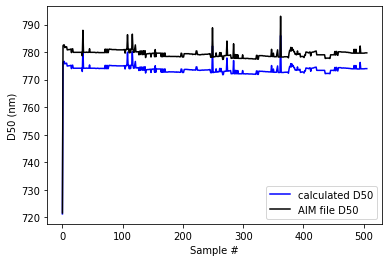

In [95]:
#######################################
#             From AIM file           #
#######################################

from mypysmps.io.read import read # import module

# get correct data path
paths = os.getcwd().split('/')[:-2]
newpath = '/' + os.path.join(*paths)+ '/testdata/'
newpath = '/work/aerosol-try/data/testdata/'
filename = os.path.join(newpath, 'LongTerm.csv')

# read SMPS data
SMPS = read(filename)

# get / transform relevant variables

n = np.asarray(SMPS.viscosity['data']) * 10 # Pa s to g/(cm s)
W = float(SMPS.metadata['Impactor (cm)'])
RhoP = np.asarray(SMPS.density['data'])
Q = np.asarray(SMPS.aerosol_flow['data'])*1000/60 # L/min to cm^3/s
lm = np.asarray(SMPS.mean_free_path['data']) * (10**9) # m to nm
Dp = np.asarray(SMPS.upper_size['data'])

# calculate D50 for all values in file
allD50 = calcD50(n, W, RhoP, Q, lm, Dp)*10**7

# compare with D50 given in AIM file
AIMD50 = SMPS.D50['data']

fig, ax = plt.subplots()
ax.plot(np.arange(len(allD50)), allD50, color = 'b', label = 'calculated D50')
ax.plot(np.arange(len(AIMD50)), AIMD50, color = 'k', label = 'AIM file D50')
ax.set_xlabel('Sample #')
ax.set_ylabel('D50 (nm)')
lgd = ax.legend()


In [94]:
display(Javascript('IPython.notebook.execute_cells_below()'))

<IPython.core.display.Javascript object>

In [92]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [93]:
#######################################
#             Interactively           #
#######################################

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))
    
button = widgets.Button(description="Reset values")
button.on_click(run_all)
display(button)

Button(description='Reset values', style=ButtonStyle())

In [89]:
#######################################
#             Inputs                  #
#######################################

n = widgets.BoundedFloatText( value=1.84341 * 10**-5, min=1.84246*10**-5,max=1.86001*10**-4,step=1.*10**-6,
                               description='Gas viscosity $Pa.s$ or $g/(cm.s)$:', style = {'description_width': 'initial'}, disabled=False, 
                               continuous_update=True, orientation='horizontal', readout=True, readout_format='.8f', 
                               tooltip = ('Reference gas viscosity'))

unitselect_n = widgets.ToggleButtons(options=['Pa-s', 'g/(cm-s)'], description='Gas viscosity units:', disabled=False,
                                     style =  {'description_width': 'initial'}, tooltips=['Pa-s units','g/(cm-s) units'])

W = widgets.BoundedFloatText( value=0.0508, min=0.0457, max=0.06, step=0.0001, description='Nozzle diameter $cm$:', 
                             style = {'description_width': 'initial'}, disabled=False, continuous_update=True, orientation='horizontal', readout=True,
                             readout_format='.4f', tooltip = ('Diameter of aerosol inlet'))

RhoP = widgets.BoundedFloatText( value=1.0000, min=0, max=1.5,step=0.1, description='Particle Density $g/cm3$:', style = {'description_width': 'initial'},
                                disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.1f', 
                                tooltip = ('Particle density'))

Q = widgets.BoundedFloatText( value=0.373, min=0, max=6.5, step=.001, description='Aerosol Flow Rate $L/min$ or $cm3/s$:', 
                             style = {'description_width': 'initial'}, disabled=False, continuous_update=True, orientation='horizontal', readout=True,
                             readout_format='.3f', tooltip = ('Aerosol volumetric flow rate'))

unitselect_flowrate =  widgets.ToggleButtons(options=['L/min', 'cm3/s'], description='volumetric flow rate:', disabled=False, 
                                             style =  {'description_width': 'initial'}, tooltips=['L/min units','cm3/s units'])

lm = widgets.BoundedFloatText( value=69.06, min=67.000, max=70.000, step=0.001, description='mean free path $nm$:', 
                              style = {'description_width': 'initial'}, disabled=False, continuous_update=True, orientation='horizontal', readout=True,
                              readout_format='.2f', tooltip = ('Mean free path'))

Dp = widgets.BoundedFloatText( value=749.9, min=4.37, max=750, step=0.1, description='Particle diameter $nm$:',style = {'description_width': 'initial'},
                              disabled=False, continuous_update=True, orientation='horizontal', readout=True, readout_format='.1f', 
                              tooltip = ('Particle diameter'))


#######################################
#             Outputs                 #
#######################################

def showKnC(lm:lm, Dp:Dp, tprint = True):
    Kncalc = calcKn(lm, Dp)
    Ccalc = calcC(Kncalc)
    if tprint:
        print( ('Knudsen number: ' + '%.9f')%(Kncalc) )
        print( ('Cunningham Slip Correction: ' + '%.9f')%(Ccalc) )
    return Kncalc, Ccalc

def showD50(lm, Dp, RhoP, Q, n, W, nselect, fselect):
    Kncalc = calcKn(lm, Dp)
    C = calcC(Kncalc)
    if nselect == 'Pa-s':
        n = n*10
    if fselect == 'L/min':
        Q = Q*1000/60
    calcD50 = D50(n, W, RhoP, Q, C, Stk50 = 0.23)* 10**7
    print( ('D50 (nm): ' + '%.9f')%(calcD50) )

outs1 =  widgets.interactive_output(showKnC,{'lm': lm, 'Dp': Dp} )
outs2 =  widgets.interactive_output(showD50,{'lm':lm,'Dp':Dp, 'RhoP':RhoP,'Q':Q,'n':n,'W':W,'nselect':unitselect_n, 'fselect':unitselect_flowrate} )

#######################################
#             Widgets                 #
#######################################


ui = widgets.VBox([n, unitselect_n, W, RhoP, Q, unitselect_flowrate, lm, Dp])
ui2 = widgets.VBox([outs1,outs2])

uif = widgets.HBox([ui, ui2])

display(uif)
